In [16]:
using FFTW, DeconvOptim, ImageShow, TestImages, Colors, Noise, Zygote

In [2]:
img = Float32.(testimage("fabio_gray_512"))

512×512 Matrix{Float32}:
 0.521569  0.517647  0.505882  0.498039  …  0.184314  0.188235  0.188235
 0.482353  0.478431  0.466667  0.458824     0.184314  0.188235  0.188235
 0.407843  0.403922  0.392157  0.392157     0.184314  0.184314  0.184314
 0.372549  0.368627  0.352941  0.356863     0.184314  0.184314  0.184314
 0.384314  0.376471  0.360784  0.360784     0.180392  0.180392  0.180392
 0.384314  0.376471  0.364706  0.360784  …  0.180392  0.180392  0.180392
 0.372549  0.364706  0.352941  0.352941     0.176471  0.180392  0.180392
 0.368627  0.360784  0.34902   0.34902      0.176471  0.180392  0.180392
 0.368627  0.360784  0.34902   0.34902      0.176471  0.176471  0.176471
 0.372549  0.364706  0.352941  0.352941     0.176471  0.176471  0.176471
 0.376471  0.372549  0.360784  0.356863  …  0.176471  0.176471  0.176471
 0.380392  0.376471  0.368627  0.364706     0.176471  0.176471  0.176471
 0.384314  0.380392  0.372549  0.368627     0.180392  0.180392  0.180392
 ⋮                        


## More complex forward 
Imagine a measurement system which observe two regions but with two images and different intensity

In [3]:
x = Float32.(range(-1, 1, length=512))
psf = ifftshift(exp.(- (x.^2 .+ x'.^2) / 0.0005f0))
psf ./= sum(psf)
otf = rfft(psf)

psf2 = ifftshift(exp.(- (x.^2 .+ x'.^2) / 0.001f0))
psf2 ./= sum(psf2) .* 3
otf2 = rfft(psf2)


function forward(img)
    img_1 = irfft(rfft(img) .* otf, 512)
    img_2 = irfft(rfft(img) .* otf2, 512)
    img_3 = irfft(rfft(img) .* otf2 .* 10, 512)

    
    img_1_z = Zygote.@ignore ones(eltype(img), size(img))
    img_2_z = Zygote.@ignore copy(img_1_z)
    img_3_z = Zygote.@ignore zeros(eltype(img), size(img))
    
    Zygote.@ignore img_1_z[1:250, 1:250] .= 0
    Zygote.@ignore img_2_z[150:end, 150:end] .= 0
    Zygote.@ignore img_3_z[150:250, 150:250] .= 1

    return img_1 .* img_1_z, img_2 .* img_2_z, img_3 .* img_3_z
end




loss_single_img = Poisson()

function loss(measurement, forward)
    return sum(loss_single_img.(measurement, forward))
    return loss_single_img(measurement[1], forward[1]) + loss_single_img(measurement[2], forward[2])
end

loss (generic function with 1 method)

In [4]:
measurements = forward(img)

(Float32[0.0 0.0 … 0.42997453 0.44288903; 0.0 0.0 … 0.3924746 0.40710458; … ; 0.5242051 0.5338961 … 0.50580025 0.51466864; 0.49102154 0.5023596 … 0.46859336 0.47954917], Float32[0.15228832 0.15523809 … 0.14647916 0.14934114; 0.14408621 0.14727227 … 0.13773194 0.14087509; … ; 0.16838425 0.17082441 … 0.0 0.0; 0.16048288 0.16318136 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

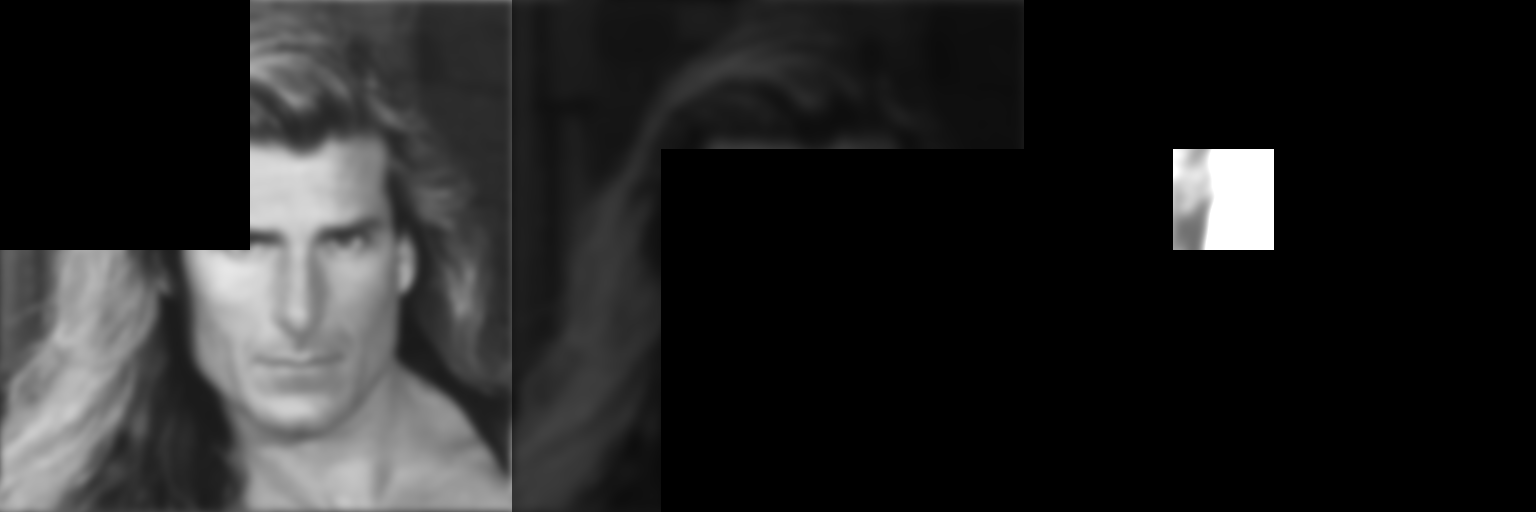

In [5]:
[Gray.(measurements[1]) Gray.(measurements[2]) Gray.(measurements[3])]

## Create initial guess

In [6]:
rec0 = 5f-1 .* ones(eltype(img), size(img));

In [7]:
reg = nothing#TV()

In [18]:
@time res, optim_res = invert(measurements, rec0, forward, loss=loss, regularizer=reg, iterations=100)

  1.529767 seconds (59.12 k allocations: 3.732 GiB, 8.12% gc time)


(Float32[0.45705828 0.4843457 … 0.40347588 0.4292058; 0.39134446 0.42217824 … 0.33081618 0.35990334; … ; 0.5963754 0.6117581 … 0.56959605 0.5817957; 0.5288577 0.5507823 … 0.48681384 0.5067938],  * Status: success

 * Candidate solution
    Final objective value:     1.993935e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.37e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    36
    f(x) calls:    56
    ∇f(x) calls:   36
)

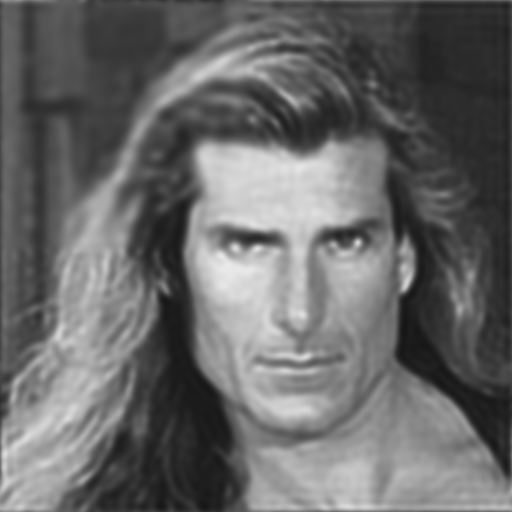

In [9]:
Gray.(res)

## Bringing that to CUDA
We need to ensure that all array are `CuArray`s and then everything works

In [19]:
using CUDA

In [20]:
otf_c = CuArray(otf)
otf2_c = CuArray(otf2)
img_c = CuArray(img)

p = plan_rfft(img_c)
p_inv = inv(p)

function forward_c(img)
    # use plan and p_inv.scale because of a Zygote and CUDA bug
    img_1 = p_inv.scale .* (p_inv.p * ((p * img) .* otf_c))
    img_2 = p_inv.scale .* (p_inv.p * ((p * img) .* otf2_c))
    img_3 = p_inv.scale .* (p_inv.p * ((p * img) .* otf2_c .* 10))

    
    img_1_z = Zygote.@ignore CUDA.ones(eltype(img), size(img))
    img_2_z = Zygote.@ignore copy(img_1_z)
    img_3_z = Zygote.@ignore CUDA.zeros(eltype(img), size(img))
    
    Zygote.@ignore img_1_z[1:250, 1:250] .= 0
    Zygote.@ignore img_2_z[150:end, 150:end] .= 0
    Zygote.@ignore img_3_z[150:250, 150:250] .= 1

    return img_1 .* img_1_z, img_2 .* img_2_z, img_3 .* img_3_z
end

forward_c (generic function with 1 method)

In [21]:
measurements_c = forward_c(CuArray(img))

(Float32[0.0 0.0 … 0.42997444 0.44288898; 0.0 0.0 … 0.39247444 0.4071045; … ; 0.524205 0.53389597 … 0.50580007 0.51466846; 0.4910215 0.5023596 … 0.46859318 0.47954905], Float32[0.15228832 0.15523806 … 0.1464791 0.14934112; 0.14408618 0.14727226 … 0.1377319 0.14087507; … ; 0.16838422 0.17082438 … 0.0 0.0; 0.16048285 0.16318135 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [22]:
rec0_c = 5f-1 .* CUDA.ones(eltype(img), size(img));

In [25]:
@time res, optim_res = invert(measurements_c, rec0_c, forward_c, loss=loss, regularizer=reg, iterations=100)

  0.155915 seconds (474.34 k allocations: 13.040 MiB, 7.23% gc time)


(Float32[0.45655286 0.48253846 … 0.40542063 0.4300504; 0.39226323 0.42153326 … 0.33463636 0.36241972; … ; 0.5931451 0.6082777 … 0.5664335 0.57872015; 0.5267008 0.5477958 … 0.48611975 0.5054795],  * Status: success

 * Candidate solution
    Final objective value:     1.993936e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.92e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    30
    f(x) calls:    52
    ∇f(x) calls:   30
)

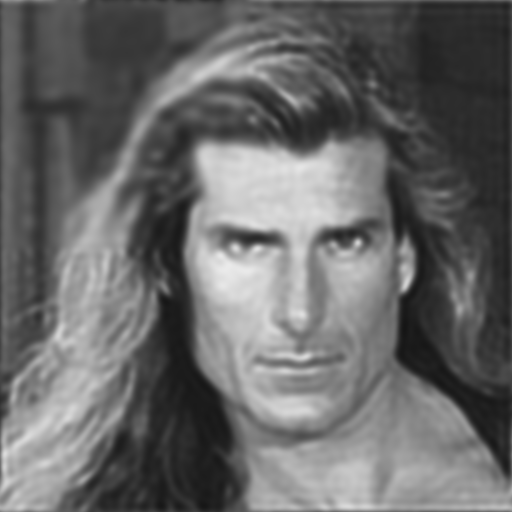

In [26]:
Gray.(Array(res))